## General Peng-Robinson Cubic Equation of State Solver

I originally started working on this problem because I wanted a better understanding of how classes worked in Python and wanted to use a problem I already understood to do so. With the benefit of hindsight I _probably_ wouldn't have done it this way, but it's functional so here we are.

The [Peng-Robinson Equation of State](https://en.wikipedia.org/wiki/Equation_of_state#Peng%E2%80%93Robinson_equation_of_state) is a cubic equation of state for relating Temperature, Pressure, and vapor density similar to the ideal gas law typically presented in high school chemistry, or the van der Waals equation of state typically presented in freshman chemistry. It does a better job than either of those by introducting terms that give particles volume (ideal gas law assumes point particles), as well as allowing electrostatic interactions between particles.

Outline of what's available here:
* Setup of python classes for pure components and mixtures of components
* Building out a [Full-Factorial](https://en.wikipedia.org/wiki/Factorial_experiment) experiment for determining mole fractions of components based on Temperature and Pressure
* A simple neural network of the results using sklearn

First, we need to import libraries:

In [1]:
import os
import numpy as np
import pandas as pd
import scipy.optimize
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import inv
import copy

Next I was unable to find a cubic solver that I liked, so I wrote my own. This function takes two derived terms from the Peng-Robinson EOS and finds the roots of the equation. Specifically it finds the highest of 3 roots if it exists, which is the factor we need for the vapor phase

In [2]:
def PengRobinsonCubic(A,B,root=2):
        coeff = [A/A,B-1,A-2*B-3*B**2,B**3+B**2-A*B]
        a = coeff[0]
        b = coeff[1]
        c = coeff[2]
        d = coeff[3]
        
        p = (3 * a * c - b ** 2) / (3 * a ** 2)
        q = (2 * (b ** 3) - 9 * a * b * c + 27 * (a ** 2) * d) / (27 * a ** 3)
        discriminant = 18 * a * b * c * d - 4 * (b ** 3) * d + (b ** 2) * (c ** 2) - 4 * a * (c ** 3) - 27 * (a ** 2) * (d ** 2)
        
        if discriminant > 0: #there are 3 real roots
            return 2 * ((-p / 3) ** (1 / 2)) * np.cos((1 / 3) * np.arccos(((3 * q) / (2 * p)) * ((-3 / p) ** (1 / 2))) - 2 * np.pi * root / 3) - b / (3 * a)
        elif p > 0:
            return -2 * ((p / 3) ** (1 / 2)) * np.sinh((1 / 3) * np.arcsinh(((3 * q) / (2 * p)) * ((3 / p) ** (1 / 2)))) - b / (3 * a)
        else:
            return -2 * (np.abs(q) / q) * ((-p / 3) ** (1 / 2)) * np.cosh((1 / 3) * np.arccosh(((-3 * np.abs(q)) / (2 * p)) * ((-3 / p) ** (1 / 2)))) - b / (3 * a)


Next we need to worry about all the math behind the Peng-Robinson EOS, which we can do using two classes. One for pure species components and the other for mixtures. The class for mixtures also needs a solver to get a solution for the mole fractions. This is accomplished with scipy.optimize.least_squares and some linear algebra involving mole fractions adding up to 1 and fugacities.

The pure species class has optional terms for PSVR2.

When the mixture model does not converge, numbers for np.nan will be used instead.

For units:
* Temperature is in Celcius
* Pressure is in Barg
* Volume is in L

In [3]:
class component:
    def __init__(self, Tc, Pc, omega, kappa1=0, kappa2=0, kappa3=0):
        self.Tc = Tc
        self.Pc = Pc
        self.omega = omega
        self.kappa1 = kappa1
        self.kappa2 = kappa2
        self.kappa3 = kappa3
        
    def setConditions(self,P,T):
        P = np.array(P)
        T = np.array(T)
        Tc = self.Tc
        Pc = self.Pc
        omega = self.omega
        kappa1 = self.kappa1
        kappa2 = self.kappa2
        kappa3 = self.kappa3
        T = T + 273.15
        P = P + 1.01325
        R = 0.083144626 #(Bar*L)/(mol*K)
        self.R = R
        
        Tr = T / Tc
        self.Tr = Tr
        
        self.kappa0 = 0.378893+1.4897153*omega-.17131848*omega**2+0.0196554*omega**3
        self.kappa = self.kappa0 + (kappa1+kappa2*(kappa3-Tr)*(1-np.sqrt(Tr)))        
        self.alpha = (1+self.kappa*(1-np.sqrt(Tr)))**2
        
        self.a = 0.45724*(R**2)*(Tc**2)/Pc
        self.b = 0.07780*R*Tc/Pc
        
        self.A = (self.a*self.alpha*P)/(self.R**2*T**2)
        self.B = (self.b*P)/(self.R*T)
        
        self.Psat = np.exp(np.log(self.Pc)+np.log(10)*(1-1/Tr)*(7+7*self.omega)/3)
        
        self.Z = PengRobinsonCubic(self.A,self.B)
        
        self.Vn = self.Z*self.R*T/P

        

In [4]:
class mixture:
    def __init__(self,component1,component2,k=0):
        self.component1 = copy.deepcopy(component1)
        self.component2 = copy.deepcopy(component2)
        self.k = k
        
    def setMixtureConditions(self,P,T):
        P = np.array(P)
        T = np.array(T)
        self.P = P + 1.01325
        self.T = T + 273.15
        self.component1.setConditions(P,T)
        self.component2.setConditions(P,T)
#         initialize the mole fractions using Raoult's law as a starting point
        Raoult = np.array([[1,0,self.component1.Psat,0],[1,0,0,self.component2.Psat],[0,1,-P+10**-10,0],[0,1,0,-P+10**-10]])
        SolveAgainst = np.array([1,1,0,0])
        [self.x1, self.x2, self.y1, self.y2] = SolveAgainst.dot(inv(Raoult))
        
    def solveMoleFractions(self):
        guess = [self.x1, self.y1]
        MoleFractions = scipy.optimize.least_squares(self.F,guess)
        self.convergance = MoleFractions.success
        self.x1, self.y1 = MoleFractions.x
        if not(0 <= (self.x1 or self.y1) <= 1):
            self.x1, self.y1 = np.nan, np.nan
            return [np.nan, np.nan]
        elif np.round((self.x1+10**-10)/(self.y1+10**-10),4) == 1:
            return [np.nan, np.nan]
        else:
            return MoleFractions.x
       
    def F(self,z):
        x1 = z[0]
        y1 = z[1]
        x2 = 1 - x1
        y2 = 1 - y1
        P = self.P
        T = self.T
        R = 0.083144626 #(mL*psi)/(mol*K)
        aa1 = self.component1.a*self.component1.alpha
        aa2 = self.component2.a*self.component2.alpha
        aL = self.component1.a*self.component1.alpha*x1**2+2*x1*x2*(1-self.k)*np.sqrt(self.component1.a*self.component2.a*self.component1.alpha*self.component2.alpha)+self.component2.a*self.component2.alpha*x2**2
        aV = self.component1.a*self.component1.alpha*y1**2+2*y1*y2*(1-self.k)*np.sqrt(self.component1.a*self.component2.a*self.component1.alpha*self.component2.alpha)+self.component2.a*self.component2.alpha*y2**2
        
        bL = x1*self.component1.b+x2*self.component2.b
        bV = y1*self.component1.b+y2*self.component2.b
        
        AL = (aL*P)/(R**2*T**2)
        BL = (bL*P)/(R*T)
        AV = (aV*P)/(R**2*T**2)
        BV = (bV*P)/(R*T)
        
        ZV = PengRobinsonCubic(AV,BV)
        ZL = PengRobinsonCubic(AL,BL)
        
        self.ZV, self.ZL = ZV, ZL

        term1L = -np.log(ZL-BL)
        term2L1 = (ZL-1)*self.component1.b/bL
        term2L2 = (ZL-1)*self.component2.b/bL
        term3L = (AL/(BL*np.sqrt(8)))*np.log((ZL+BL*(np.sqrt(2)+1))/(ZL-BL*(np.sqrt(2)-1)))
        term3L1 = (2/aL)*((1-x1)*((1-self.k)*np.sqrt(self.component1.a*self.component1.alpha*self.component2.a*self.component2.alpha))+x1*self.component1.a*self.component1.alpha)-self.component1.b/bL
        term3L2 = (2/aL)*((1-x2)*((1-self.k)*np.sqrt(self.component1.a*self.component1.alpha*self.component2.a*self.component2.alpha))+x2*self.component2.a*self.component2.alpha)-self.component2.b/bL
        
        fugL1 = np.exp(term1L + term2L1 - term3L*term3L1)
        fugL2 = np.exp(term1L + term2L2 - term3L*term3L2)
        
        term1V = -np.log(ZV-BV)
        term2V1 = (ZV-1)*self.component1.b/bV
        term2V2 = (ZV-1)*self.component2.b/bV
        term3V = (AV/(BV*np.sqrt(8)))*np.log((ZV+BV*(np.sqrt(2)+1))/(ZV-BV*(np.sqrt(2)-1)))
        term3V1 = (2/aV)*((1-y1)*((1-self.k)*np.sqrt(self.component1.a*self.component1.alpha*self.component2.a*self.component2.alpha))+y1*self.component1.a*self.component1.alpha)-self.component1.b/bV
        term3V2 = (2/aV)*((1-y2)*((1-self.k)*np.sqrt(self.component1.a*self.component1.alpha*self.component2.a*self.component2.alpha))+y2*self.component2.a*self.component2.alpha)-self.component2.b/bV
        
        fugV1 = np.exp(term1V + term2V1 - term3V*term3V1)
        fugV2 = np.exp(term1V + term2V2 - term3V*term3V2)
        
        self.fugL1, self.fugL2, self.fugV1, self.fugV2 = fugL1, fugL2, fugV1, fugV2
        
        Left = np.array([[1,0,fugL1,0],[1,0,0,fugL2],[0,1,-fugV1,0],[0,1,0,-fugV2]])
        Right = np.array([1,1,0,0])
        Solution = np.array(Right.dot(inv(Left)))
        
        return (1000*(Solution[0]-x1))**2 + (1000*(Solution[2]-y1))**2
        

To actually use the Peng-Robinson EOS, we need to know 3 properties of each component:
* Critical Temperature
* Critical Pressure
* [Acentric Factor](https://en.wikipedia.org/wiki/Acentric_factor) (which can be derived from the boiling point, commonly written with the greek letter omega)

Critical properties can be obtained from [NIST](https://webbook.nist.gov/chemistry/) or other resources.

As an example, let's look at a binary system with carbon dioxide and ethanol at 5 bar and 40C

In [5]:
CO2 = component(Tc=304.2, Pc=73.80, omega=0.228, kappa1 = 0.04285)
Ethanol = component(Tc=514, Pc=63, omega=.644)

myMixture = mixture(CO2,Ethanol,k=0)
myMixture.setMixtureConditions(P=5, T=40)
[LiquidMoleFractionCO2, VaporMoleFractionCO2] = myMixture.solveMoleFractions()

print(f'The liquid mole fraction of CO2 is {LiquidMoleFractionCO2}')
print(f'The vapor mole fraction of CO2 is {VaporMoleFractionCO2}')


The liquid mole fraction of CO2 is 0.06402955460122187
The vapor mole fraction of CO2 is 0.9678388087613046


C:\Users\NG\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in log
C:\Users\NG\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in log


So we've done the special case of one temperature and one pressure, let's work it out across a range. Let's look at temepratures between 0C and 100C, and pressures between 0 barg and 10 barg, and put those data in a pandas dataframe.

In [6]:
numSteps = 11

Tmin = 0
Tmax = 100

Pmin = 0
Pmax = 10

setup = [[Temp, Pressure]
         for Temp in np.linspace(Tmin, Tmax, num=numSteps)
         for Pressure in np.linspace(Pmin, Pmax, num=numSteps)]

dfMoleFractionData = pd.DataFrame(data=setup, columns=['Temperature (C)','Pressure (Barg)'])
dfMoleFractionData['x1'] = ''
dfMoleFractionData['y1'] = ''

dfMoleFractionData.head()

,Temperature (C),Pressure (Barg),x1,y1
0,0.0,0.0,,
1,0.0,1.0,,
2,0.0,2.0,,
3,0.0,3.0,,
4,0.0,4.0,,


It's at this point the way the classes are set up doesn't lend itself well to vectorizing the problem. If we could vectorize it, it would be very fast; but a fleeting attempt to modify it showed it to be challenging. For what I'm trying to accomplish here, time isn't critical and the time it would take to allow vectorization is several orders of magnitude higher than how long it takes the script to run.

So we'll loop through each combination of Temperature and Pressure and return the mole fractions of CO2.

In [7]:
%%time
for i in np.arange(len(dfMoleFractionData)):
    myMixture.setMixtureConditions(dfMoleFractionData['Pressure (Barg)'].iloc[i],dfMoleFractionData['Temperature (C)'].iloc[i])
    dfMoleFractionData['x1'].iloc[i], dfMoleFractionData['y1'].iloc[i] = myMixture.solveMoleFractions()
    
dfMoleFractionData['x2'] = 1 - dfMoleFractionData['x1']
dfMoleFractionData['y2'] = 1 - dfMoleFractionData['y1']

C:\Users\NG\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\NG\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in log
C:\Users\NG\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in log


Wall time: 15.2 s


In [8]:
dfMoleFractionData.tail(10)

,Temperature (C),Pressure (Barg),x1,y1,x2,y2
111,100.0,1.0,NaN,NaN,NaN,NaN
112,100.0,2.0,NaN,NaN,NaN,NaN
113,100.0,3.0,NaN,NaN,NaN,NaN
114,100.0,4.0,NaN,NaN,NaN,NaN
115,100.0,5.0,NaN,NaN,NaN,NaN
116,100.0,6.0,0.0264851,0.655533,0.973515,0.344467
117,100.0,7.0,0.0320651,0.695766,0.967935,0.304234
118,100.0,8.0,0.0376319,0.727079,0.962368,0.272921
119,100.0,9.0,0.0431858,0.752134,0.956814,0.247866
120,100.0,10.0,0.0487268,0.772629,0.951273,0.227371


It's also a good idea to plot the data to make sure it looks reasonable. We're also going to remove the numbers where Peng-Robinson didn't converge.

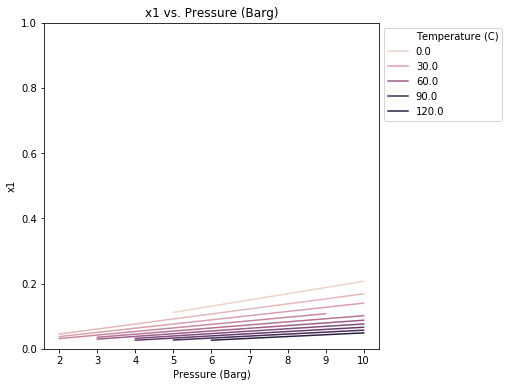

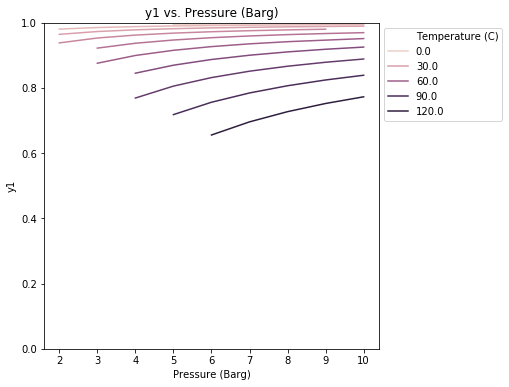

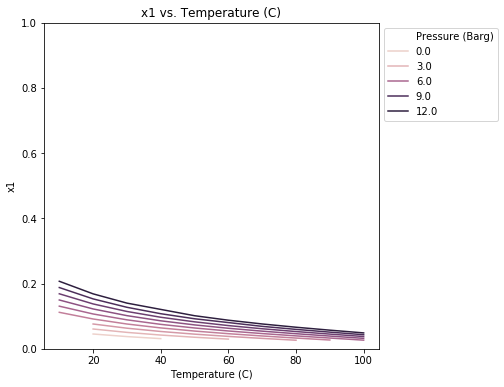

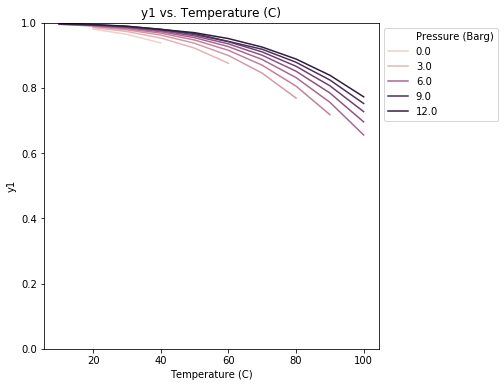

In [15]:
for column in dfMoleFractionData.columns:
    dfMoleFractionData[column] = pd.to_numeric(dfMoleFractionData[column], errors ='coerce')

PlotWidth = 6
for Condition1, Condition2 in ['Pressure (Barg)', 'Temperature (C)'], ['Temperature (C)', 'Pressure (Barg)']:
    for MoleFraction in ['x1', 'y1']:
    
        plt.figure(figsize=(PlotWidth,PlotWidth))
        plt.ylim(0,1)
        sns.lineplot(x=Condition1, y=MoleFraction, data=dfMoleFractionData, hue=Condition2)
        plt.title(f'{MoleFraction} vs. {Condition1}')
        plt.legend(bbox_to_anchor=(1,1), loc="upper left")
        plt.show()



Which looks reasonable.

So that was a lot of work to get vapor and liquid mole fractions. We can bypass using Peng-Robinson by fitting a Neural Netork model to the output and just using the results of that. We're building a model on a model, which has problems; but could be computationally time-saving in a down stream application.

First we need to scale the Temperature and Pressure to be on a scale of 0 to 1, otherwise the scikit-learn libraries won't work properly on them. There are built in functions to do that, but for the sake of demonstration I wrote my own.

In [10]:
def ScaleTheThing(unscaled):
    scaled = (unscaled - unscaled.min()) / (unscaled.max() - unscaled.min())
    return scaled

def UnScaleTheThing(scaled, unscaled):
    unscaled = scaled * (unscaled.max() - unscaled.min()) + unscaled.min()
    return unscaled

Now we can set up an MLPRegressor for both the liquid and the vapor. I'm not going to tune the hyperparemeters here and just leave them at the default values.

In [11]:
myLiquidNN = MLPRegressor(solver='lbfgs')
myVaporNN = MLPRegressor(solver='lbfgs')

In [12]:
dfMoleFractionData.dropna(inplace=True)
X_unscaled = dfMoleFractionData[['Temperature (C)', 'Pressure (Barg)']]
X = ScaleTheThing(X_unscaled)
LiquidMoleFraction = ScaleTheThing(dfMoleFractionData['x1'])
VaporMoleFraction = ScaleTheThing(dfMoleFractionData['y1'])

myLiquidNN.fit(X=X, y=LiquidMoleFraction)
myVaporNN.fit(X=X, y=VaporMoleFraction)

print(f'Liquid Score: {myLiquidNN.score(X, LiquidMoleFraction)}')
print(f'Vapor Score: {myVaporNN.score(X, VaporMoleFraction)}')

Liquid Score: 0.9996924476701617
Vapor Score: 0.9989100570730125


Both give strong r^2 values, but once again it's wise to plot it.

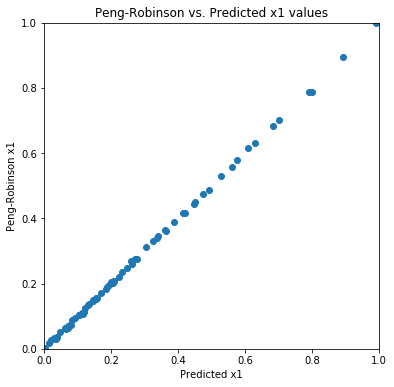

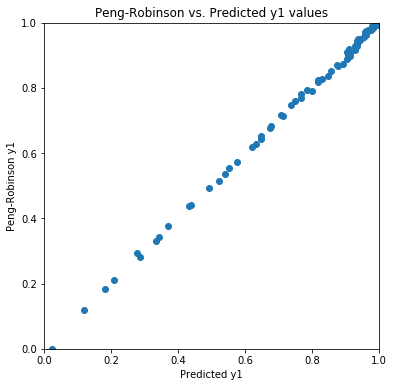

In [13]:
plt.figure(figsize=(PlotWidth, PlotWidth))
plt.xlim(0,1)
plt.ylim(0,1)
plt.scatter(x=myLiquidNN.predict(X),y=LiquidMoleFraction)
plt.xlabel('Predicted x1')
plt.ylabel('Peng-Robinson x1')
plt.title('Peng-Robinson vs. Predicted x1 values')
plt.show()

plt.figure(figsize=(PlotWidth, PlotWidth))
plt.xlim(0,1)
plt.ylim(0,1)
plt.scatter(x=myVaporNN.predict(X),y=VaporMoleFraction)
plt.xlabel('Predicted y1')
plt.ylabel('Peng-Robinson y1')
plt.title('Peng-Robinson vs. Predicted y1 values')
plt.show()



Finally let's put the predicted values back in our DataFrame

In [14]:
dfMoleFractionData['Predicted x1'] = myLiquidNN.predict(X)
dfMoleFractionData['Predicted y1'] = myVaporNN.predict(X)
display(dfMoleFractionData.head(10))

,Temperature (C),Pressure (Barg),x1,y1,x2,y2,Predicted x1,Predicted y1
16,10.0,5.0,0.111839,0.994675,0.888161,0.005325,0.474844,0.997009
17,10.0,6.0,0.130713,0.995390,0.869287,0.004610,0.576207,0.997782
18,10.0,7.0,0.149660,0.995925,0.850340,0.004075,0.682564,0.998438
19,10.0,8.0,0.168688,0.996342,0.831312,0.003658,0.790976,1.002285
20,10.0,9.0,0.187807,0.996676,0.812193,0.003324,0.893190,1.009951
21,10.0,10.0,0.207029,0.996948,0.792971,0.003052,0.992390,1.017616
24,20.0,2.0,0.045347,0.980226,0.954653,0.019774,0.116246,0.945880
25,20.0,3.0,0.060692,0.984993,0.939308,0.015007,0.189271,0.958627
26,20.0,4.0,0.076043,0.987856,0.923957,0.012144,0.275097,0.968258
27,20.0,5.0,0.091403,0.989765,0.908597,0.010235,0.365018,0.977960


From here, one could iterate over the Tc, Pc, Acentric Factor for any 2-component system at a range of temperatures and pressures.